# SV Data Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os, sys
desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/structural_variants/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/structural_variants/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)
#DATA_PATH='/Users/jocelynornelasmunoz/Desktop/structural_variants/data/simulated/4p_4c_coverage'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")
from sklearn import metrics
from sklearn.preprocessing import label_binarize
import scipy.io as sio
sys.path.insert(0,path+ 'lib/pyfiles/')
#import confusion_matrix as confmat

Using path =  /Users/jocelynornelasmunoz/Desktop/Research/structural_variants/


In [10]:
# ordered lists 
curve_suffix = {'nt': 'NEBULA Total', 
              'st': 'SPIRAL total',
              'np_2': 'NEBULA Parent Homogeneous',  
              'np_1': 'NEBULA Parent Heterogeneous',  
              'sp_2': 'SPIRAL Parent Homogeneous',  
              'sp_1': 'SPIRAL Parent Heterogeneous', 
              'nc_2h': 'NEBULA Child Inherited Homogeneous', 
              'nc_1h': 'NEBULA Child Inherited Heterogeneous', 
              'sc_2h': 'SPIRAL Child Inherited Homogeneous', 
              'sc_1h': 'SPIRAL Child Inherited Heterogeneous',
              'nc_2n': 'NEBULA Child Novel Homogeneous', 
              'nc_1n': 'NEBULA Child Novel Heterogeneous', 
              'sc_2n': 'SPIRAL Child Novel Homogeneous', 
              'sc_1n': 'SPIRAL Child Novel Heterogeneous'}

true_signals = ['f_true', 'f_true', 
                'z_p', 'y_p', 'z_p', 'y_p',
                'z_h', 'y_h', 'z_h', 'y_h',
                'z_n', 'y_n', 'z_n', 'y_n'] 
recon_signals= ['fhatNEBULA','fhatSPIRAL',
                 'fhatNEBULA_zp', 'fhatNEBULA_yp', 'fhatSPIRAL_zp', 'fhatSPIRAL_yp',
                 'fhatNEBULA_zh', 'fhatNEBULA_yh', 'fhatSPIRAL_zh', 'fhatSPIRAL_yh',
                 'fhatNEBULA_zn', 'fhatNEBULA_yn', 'fhatSPIRAL_zn', 'fhatSPIRAL_yn',]

In [99]:
# load result file
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_1e-01eps_1tau_5gamma_RESULTS.mat' #almost all good ROC, novel not great
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_5e-02eps_1.5tau_15gamma_RESULTS.mat' # no good
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_5e-02eps_1tau_7gamma_RESULTS.mat' # good inherited hetero 
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_5e-02eps_1tau_2gamma_RESULTS.mat' # most roc except novel, good parent and inherited homozygous
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_5e-02eps_5tau_10gamma_RESULTS.mat' #only good wih hetero novel
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_5e-01eps_5tau_10gamma_RESULTS.mat' #total and homoz PR ok (relatively)
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_1e-01eps_5tau_10gamma_RESULTS.mat' #bad
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_1e-01eps_1tau_5gamma_RESULTS.mat' #mostly good ROC, except novel hetero
#filename = 'results/100000n_5000k/5Lp_5Lc/diploid_4pctNovel_80pctSim_5e-01eps_5tau_10gamma_RESULTS.mat' #roc no good, pr some homoz ok
#filename = 'results/100000n_5000k/5Lp_5Lc/diploid_4pctNovel_80pctSim_1e-01eps_5tau_10gamma_RESULTS.mat' #roc no good, pr some homoz ok
#filename = 'results/100000n_5000k/7Lp_3Lc/diploid_4pctNovel_80pctSim_5e-01eps_5tau_10gamma_RESULTS.mat' #no good

## maybe
#filename = 'results/100000n_5000k/3Lp_7Lc/diploid_4pctNovel_80pctSim_5e-02eps_1.5tau_15gamma_RESULTS.mat' # good ROCs for homog, PR not so great
#filename = 'results/100000n_5000k/7Lp_3Lc/diploid_4pctNovel_80pctSim_1e-01eps_5tau_10gamma_RESULTS.mat' #some ROC and PR ok (maybe parent homog)


## good 
#filename = 'results/100000n_5000k/7Lp_3Lc/diploid_4pctNovel_80pctSim_5e-01eps_1tau_2gamma_RESULTS.mat' # good ROC for child inherited, homog parent, and comparable w/SPIRAL in homog novel

data_path = path + filename
d = sio.loadmat(data_path)

/opt/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [100]:
# calculate ROC and PR for plotting
# some ROC metrics already calculated, so just use them
for suffix, val in curve_suffix.items():
    # ROC Curve to display
    d[f'roc_curve_{suffix}'] = metrics.RocCurveDisplay(fpr=d[f'X_{suffix}'], tpr=d[f'Y_{suffix}'], pos_label=1, roc_auc=d[f'AUC_{suffix}'][0][0])

# calculate Precision-Recall Metrics
for key_suff, true, pred in zip(curve_suffix.keys(), true_signals, recon_signals):
    d[f'prec_{key_suff}'], d[f'recall_{key_suff}'], _ = metrics.precision_recall_curve(d[true], d[pred], pos_label=1)
    d[f'average_precision_{key_suff}'] = metrics.average_precision_score(d[true], d[pred])
    d[f'pr_curve_{key_suff}'] = metrics.PrecisionRecallDisplay(precision=d[f'prec_{key_suff}'], recall=d[f'recall_{key_suff}'], average_precision=d[f'average_precision_{key_suff}'])

In [101]:
params = {
    'r': d['r'],
    'n': d['n'],
    'k': d['k'],
    'lambda_p': d['lambda_p'],
    'lambda_c': d['lambda_c'],
    'pctNovel': d['pctNovel'],
    'erreps'  : d['erreps'],
    'pct_similarity': d['pct_similarity'],
    'tau' : d['tau'],
    'gamma': d['gamma']}
for key, val in params.items():
    print('\t', key, ':  ', np.squeeze(val))  

	 r :   1
	 n :   100000
	 k :   5000
	 lambda_p :   3
	 lambda_c :   7
	 pctNovel :   0.04
	 erreps :   0.05
	 pct_similarity :   0.8
	 tau :   1.5
	 gamma :   15


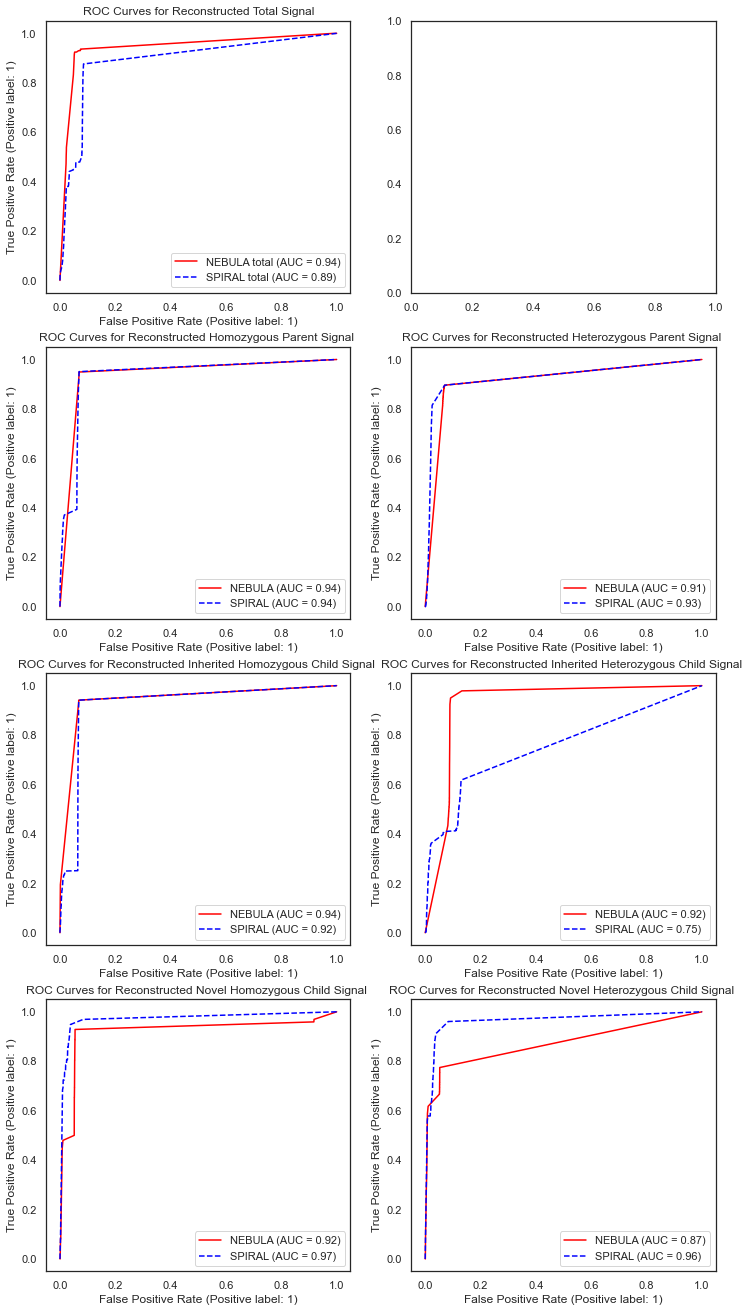

In [102]:
# Plot ROC
fig, axs = plt.subplots(4,2,figsize=(12, 23))
axs = axs.ravel()

# total
d['roc_curve_nt'].plot(ax=axs[0], name = 'NEBULA total', color='red')
d['roc_curve_st'].plot(ax=axs[0], name='SPIRAL total', linestyle='--', color='blue')
axs[0].set_title('ROC Curves for Reconstructed Total Signal')

d['roc_curve_np_2'].plot(ax=axs[2], name = 'NEBULA', color='red')
d['roc_curve_sp_2'].plot(ax=axs[2], name='SPIRAL',linestyle='--', color='blue')
axs[2].set_title('ROC Curves for Reconstructed Homozygous Parent Signal ')

d['roc_curve_np_1'].plot(ax=axs[3], name = 'NEBULA', color='red')
d['roc_curve_sp_1'].plot(ax=axs[3], name='SPIRAL', linestyle='--', color='blue')
axs[3].set_title('ROC Curves for Reconstructed Heterozygous Parent Signal ')

d['roc_curve_nc_2h'].plot(ax=axs[4], name = 'NEBULA', color='red')
d['roc_curve_sc_2h'].plot(ax=axs[4], name='SPIRAL', linestyle='--', color='blue')
axs[4].set_title('ROC Curves for Reconstructed Inherited Homozygous Child Signal ')

d['roc_curve_nc_1h'].plot(ax=axs[5], name = 'NEBULA', color='red')
d['roc_curve_sc_1h'].plot(ax=axs[5], name='SPIRAL', linestyle='--', color='blue')
axs[5].set_title('ROC Curves for Reconstructed Inherited Heterozygous Child Signal ')

d['roc_curve_nc_2n'].plot(ax=axs[6], name = 'NEBULA', color='red')
d['roc_curve_sc_2n'].plot(ax=axs[6], name='SPIRAL', linestyle='--', color='blue')
axs[6].set_title('ROC Curves for Reconstructed Novel Homozygous Child Signal ')

d['roc_curve_nc_1n'].plot(ax=axs[7], name = 'NEBULA', color='red')
d['roc_curve_sc_1n'].plot(ax=axs[7], name='SPIRAL', linestyle='--', color='blue')
axs[7].set_title('ROC Curves for Reconstructed Novel Heterozygous Child Signal ')

#fig.suptitle('ROC Curves for Reconstructed Signals')
#plt.tight_layout()
plt.show()

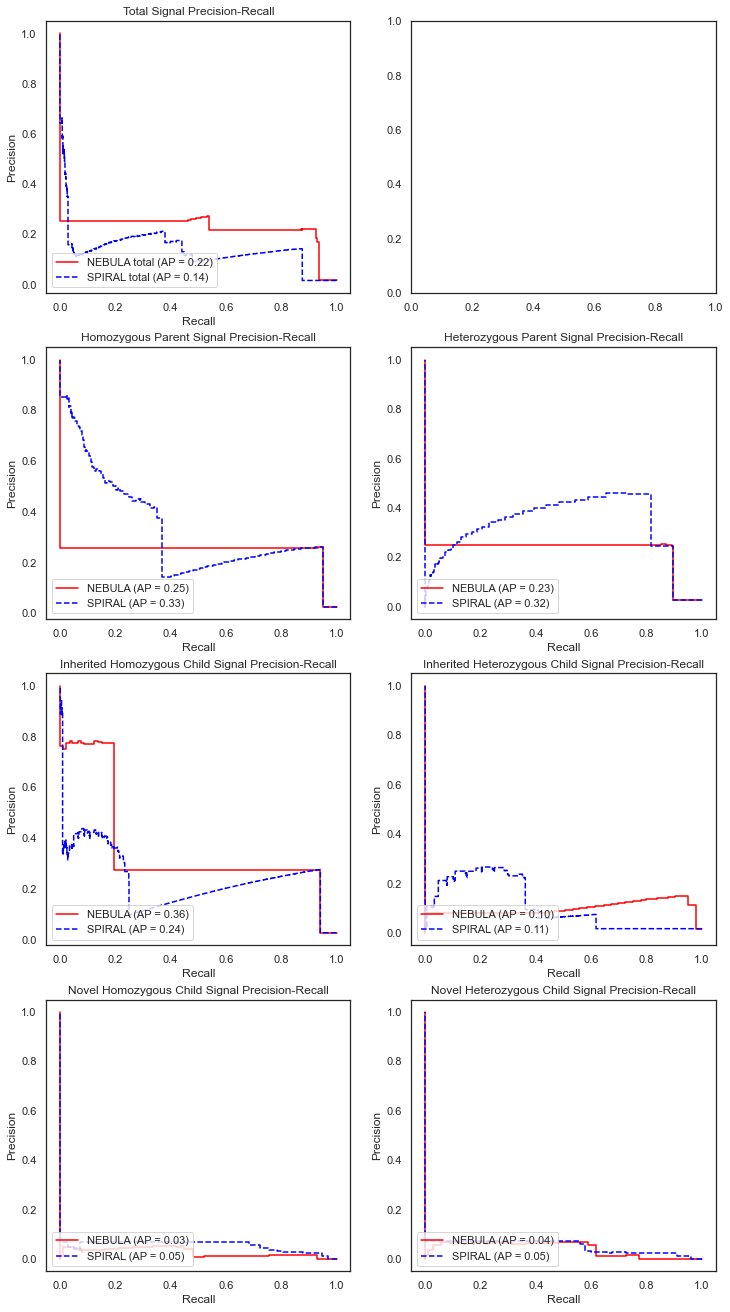

In [103]:
fig, axs = plt.subplots(4,2,figsize=(12, 23))
axs = axs.ravel()

# total
d['pr_curve_nt'].plot(ax=axs[0], name = 'NEBULA total', color='red')
d['pr_curve_st'].plot(ax=axs[0], name='SPIRAL total', linestyle='--', color='blue')
axs[0].set_title('Total Signal Precision-Recall')

d['pr_curve_np_2'].plot(ax=axs[2], name = 'NEBULA', color='red')
d['pr_curve_sp_2'].plot(ax=axs[2], name='SPIRAL', linestyle='--', color='blue')
axs[2].set_title('Homozygous Parent Signal Precision-Recall')

d['pr_curve_np_1'].plot(ax=axs[3], name = 'NEBULA', color='red')
d['pr_curve_sp_1'].plot(ax=axs[3], name='SPIRAL', linestyle='--', color='blue')
axs[3].set_title('Heterozygous Parent Signal Precision-Recall')

d['pr_curve_nc_2h'].plot(ax=axs[4], name = 'NEBULA', color='red')
d['pr_curve_sc_2h'].plot(ax=axs[4], name='SPIRAL', linestyle='--', color='blue')
axs[4].set_title('Inherited Homozygous Child Signal Precision-Recall')

d['pr_curve_nc_1h'].plot(ax=axs[5], name = 'NEBULA', color='red')
d['pr_curve_sc_1h'].plot(ax=axs[5], name='SPIRAL', linestyle='--', color='blue')
axs[5].set_title('Inherited Heterozygous Child Signal Precision-Recall')

d['pr_curve_nc_2n'].plot(ax=axs[6], name = 'NEBULA', color='red')
d['pr_curve_sc_2n'].plot(ax=axs[6], name='SPIRAL', linestyle='--', color='blue')
axs[6].set_title('Novel Homozygous Child Signal Precision-Recall')

d['pr_curve_nc_1n'].plot(ax=axs[7], name = 'NEBULA', color='red')
d['pr_curve_sc_1n'].plot(ax=axs[7], name='SPIRAL', linestyle='--', color='blue')
axs[7].set_title('Novel Heterozygous Child Signal Precision-Recall')
plt.show()

# Comparison of all results

In [3]:
filelist = []
data_path = path + 'results/100000n_50k/2Lp_4Lc/'

#list the files
filelist = os.listdir(data_path)

## Total comparison

In [4]:
rows = []
for file in filelist:
    d = sio.loadmat(data_path + file)
    # calculate ROC metrics
    d['fpr_SPIRAL_total'], d['tpr_SPIRAL_total'], d['thresholds_SPIRAL_total'] = metrics.roc_curve(d['f_true'], d['fhatSPIRAL'], pos_label=1)
    d['fpr_NEBULA_total'], d['tpr_NEBULA_total'], d['thresholds_NEBULA_total'] = metrics.roc_curve(d['f_true'], d['fhatNEBULA'], pos_label=1)
    d['roc_auc_SPIRAL_total'] = metrics.auc(d['fpr_SPIRAL_total'], d['tpr_SPIRAL_total'])
    d['roc_auc_NEBULA_total'] = metrics.auc(d['fpr_NEBULA_total'], d['tpr_NEBULA_total'])
    #d['roc_curve_St'] = metrics.RocCurveDisplay(fpr=d['fpr_SPIRAL_total'], tpr=d['tpr_SPIRAL_total'], pos_label=1, roc_auc=d['roc_auc_SPIRAL_total'])
    #d['roc_curve_Nt'] = metrics.RocCurveDisplay(fpr=d['fpr_NEBULA_total'], tpr=d['tpr_NEBULA_total'], pos_label=1, roc_auc=d['roc_auc_NEBULA_total'])

    # calculate Precision-Recall Metrics
    d['prec_st'], d['recall_st'], _ = metrics.precision_recall_curve(d['f_true'], d['fhatSPIRAL'], pos_label=1)
    d['prec_nt'], d['recall_nt'], _ = metrics.precision_recall_curve(d['f_true'], d['fhatNEBULA'], pos_label=1)
    d['average_precision_Nt'] = metrics.average_precision_score(d['f_true'], d['fhatNEBULA'])
    d['average_precision_St'] = metrics.average_precision_score(d['f_true'], d['fhatSPIRAL'])
    d['pr_curve_St'] = metrics.PrecisionRecallDisplay(precision=d['prec_st'], recall=d['recall_st'], average_precision=d['average_precision_St'])
    d['pr_curve_Nt'] = metrics.PrecisionRecallDisplay(precision=d['prec_nt'], recall=d['recall_nt'], average_precision=d['average_precision_Nt'])



    # PARENT ------------------------------------------------------------
    parent_true = label_binarize(np.squeeze(d['f_p']), classes=[0, 1, 2])
    n_classes = parent_true.shape[1]
    n = np.squeeze(d['n'])

    ## SPIRAL PARENT
    pred_p = np.zeros(parent_true.shape)
    pred_p[:,0] = d['fhatSPIRAL'][:n,0] + d['fhatSPIRAL'][3*n:4*n,0]
    pred_p[:,1] = d['fhatSPIRAL'][:n,0] + d['fhatSPIRAL'][3*n:4*n,0]
    pred_p[:,2] = d['fhatSPIRAL'][:n,0] + d['fhatSPIRAL'][3*n:4*n,0]

    # For each class
    s = 'sp'
    for i in range(n_classes):
        d['prec_%s_%i'%(s,i)], d['recall__%s_%i'%(s,i)], _ = metrics.precision_recall_curve(parent_true[:, i], pred_p[:, i])
        d['average_precision__%s_%i'%(s,i)] = metrics.average_precision_score(parent_true[:, i], pred_p[:, i])

    # A "micro-average": quantifying score on all classes jointly
    d["prec_%s_micro"%s], d["recall_%s_micro"%s], _ = metrics.precision_recall_curve(parent_true.ravel(), pred_p.ravel())
    d['average_precision__%s_micro'%(s)] = metrics.average_precision_score(parent_true, pred_p, average="micro")

    ## NEBULA PARENT
    pred_p = np.zeros(parent_true.shape)
    pred_p[:,0] = d['fhatNEBULA'][:n,0] + d['fhatNEBULA'][3*n:4*n,0]
    pred_p[:,1] = d['fhatNEBULA'][:n,0] + d['fhatNEBULA'][3*n:4*n,0]
    pred_p[:,2] = d['fhatNEBULA'][:n,0] + d['fhatNEBULA'][3*n:4*n,0]

    # For each class
    s = 'np'
    for i in range(n_classes):
        d['prec_%s_%i'%(s,i)], d['recall__%s_%i'%(s,i)], _ = metrics.precision_recall_curve(parent_true[:, i], pred_p[:, i])
        d['average_precision__%s_%i'%(s,i)] = metrics.average_precision_score(parent_true[:, i], pred_p[:, i])

    # A "micro-average": quantifying score on all classes jointly
    d["prec_%s_micro"%s], d["recall_%s_micro"%s], _ = metrics.precision_recall_curve(parent_true.ravel(), pred_p.ravel())
    d['average_precision__%s_micro'%(s)] = metrics.average_precision_score(parent_true, pred_p, average="micro")


    # CHILD ------------------------------------------------------------

    child_true = label_binarize(np.squeeze(d['f_c']), classes=[0, 1, 2])
    n_classes = child_true.shape[1]
    n = np.squeeze(d['n'])

    ## SPIRAL PARENT
    pred_c = np.zeros(child_true.shape)
    pred_c[:,0] = d['fhatSPIRAL'][n:2*n,0] + d['fhatSPIRAL'][2*n:3*n,0] + d['fhatSPIRAL'][4*n:5*n,0] +  d['fhatSPIRAL'][5*n:6*n,0]
    pred_c[:,1] = d['fhatSPIRAL'][n:2*n,0] + d['fhatSPIRAL'][2*n:3*n,0] + d['fhatSPIRAL'][4*n:5*n,0] +  d['fhatSPIRAL'][5*n:6*n,0]
    pred_c[:,2] = d['fhatSPIRAL'][n:2*n,0] + d['fhatSPIRAL'][2*n:3*n,0] + d['fhatSPIRAL'][4*n:5*n,0] +  d['fhatSPIRAL'][5*n:6*n,0]

    # For each class
    s = 'sc'
    for i in range(n_classes):
        d['prec_%s_%i'%(s,i)], d['recall__%s_%i'%(s,i)], _ = metrics.precision_recall_curve(child_true[:, i], pred_c[:, i])
        d['average_precision__%s_%i'%(s,i)] = metrics.average_precision_score(child_true[:, i], pred_c[:, i])

    # A "micro-average": quantifying score on all classes jointly
    d["prec_%s_micro"%s], d["recall_%s_micro"%s], _ = metrics.precision_recall_curve(child_true.ravel(), pred_c.ravel())
    d['average_precision__%s_micro'%(s)] = metrics.average_precision_score(child_true, pred_c, average="micro")

    ## NEBULA PARENT
    pred_p = np.zeros(parent_true.shape)
    pred_p[:,0] = d['fhatNEBULA'][n:2*n,0] + d['fhatNEBULA'][2*n:3*n,0] + d['fhatNEBULA'][4*n:5*n,0] +  d['fhatNEBULA'][5*n:6*n,0]
    pred_p[:,1] = d['fhatNEBULA'][n:2*n,0] + d['fhatNEBULA'][2*n:3*n,0] + d['fhatNEBULA'][4*n:5*n,0] +  d['fhatNEBULA'][5*n:6*n,0]
    pred_p[:,2] = d['fhatNEBULA'][n:2*n,0] + d['fhatNEBULA'][2*n:3*n,0] + d['fhatNEBULA'][4*n:5*n,0] +  d['fhatNEBULA'][5*n:6*n,0]

    # For each class
    s = 'nc'
    for i in range(n_classes):
        d['prec_%s_%i'%(s,i)], d['recall__%s_%i'%(s,i)], _ = metrics.precision_recall_curve(child_true[:, i], pred_c[:, i])
        d['average_precision__%s_%i'%(s,i)] = metrics.average_precision_score(child_true[:, i], pred_c[:, i])

    # A "micro-average": quantifying score on all classes jointly
    d["prec_%s_micro"%s], d["recall_%s_micro"%s], _ = metrics.precision_recall_curve(child_true.ravel(), pred_c.ravel())
    d['average_precision__%s_micro'%(s)] = metrics.average_precision_score(child_true, pred_c, average="micro")
    rows.append([d])
print('Done!')

/opt/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/opt/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/opt/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/opt/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Co

Done!


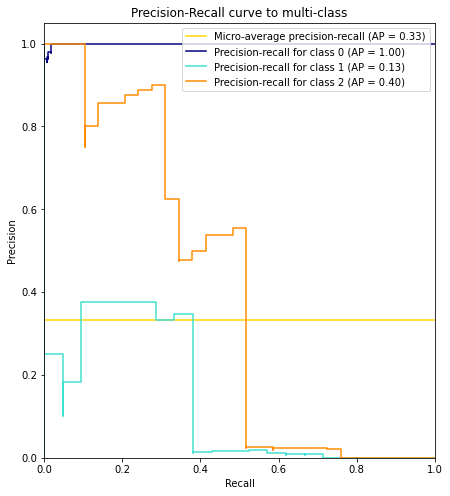

In [130]:
# setup plot details
colors = ["navy", "turquoise", "darkorange", "cornflowerblue", "teal"]

_, ax = plt.subplots(figsize=(7, 8))

display = metrics.PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = metrics.PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name="Precision-recall for class %i"%i, color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()


# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Precision-Recall curve to multi-class")

plt.show()

In [5]:
df_list = []
for i in range(len(rows)):
    df = pd.DataFrame(rows[i])
    df_list.append(df)

full_data = pd.concat(df_list)
#full_data.to_csv('10000n_5k_16Lp_4Lc.csv')

In [13]:
full_data

,__header__,__version__,__globals__,A,AT,AUC_nc,AUC_np,AUC_nt,AUC_sc,AUC_sp,...,average_precision__nc_0,prec_nc_1,recall__nc_1,average_precision__nc_1,prec_nc_2,recall__nc_2,average_precision__nc_2,prec_nc_micro,recall_nc_micro,average_precision__nc_micro
0,"b'MATLAB 5.0 MAT-file, Platform: MACI64, Creat...",1.0,[],"[[[['/Applications/MATLAB_R2022a.app'], ['/'],...","[[[['/Applications/MATLAB_R2022a.app'], ['/'],...",[[0.9809813811522583]],[[0.9233319949570362]],[[0.970602048044424]],[[0.9217354067162234]],[[0.8776302547344466]],...,0.998810,"[0.0003762617743986299, 0.00035032632248186736...","[1.0, 0.9310344827586207, 0.896551724137931, 0...",0.441982,"[0.0003461241956545681, 0.018214936247723135, ...","[1.0, 0.9090909090909091, 0.9090909090909091, ...",0.356556,"[0.3333333333333333, 0.3333333333333333, 0.333...","[1.0, 0.77074, 0.77071, 0.63561, 0.01098, 0.01...",0.333333
0,"b'MATLAB 5.0 MAT-file, Platform: MACI64, Creat...",1.0,[],"[[[['/Applications/MATLAB_R2022a.app'], ['/'],...","[[[['/Applications/MATLAB_R2022a.app'], ['/'],...",[[0.9309051349029149]],[[0.8331123345426349]],[[0.7474610948948684]],[[0.9309004783801095]],[[0.8331070953471656]],...,0.999394,"[0.00029, 0.45454545454545453, 0.5263157894736...","[1.0, 0.8620689655172413, 0.6896551724137931, ...",0.406570,"[0.00022, 0.32727272727272727, 0.4473684210526...","[1.0, 0.8181818181818182, 0.7727272727272727, ...",0.520585,"[0.3333333333333333, 0.3333333333333333, 0.333...","[1.0, 0.00055, 0.00038, 0.00037, 0.00035, 0.00...",0.333333
0,"b'MATLAB 5.0 MAT-file, Platform: MACI64, Creat...",1.0,[],"[[[['/Applications/MATLAB_R2022a.app'], ['/'],...","[[[['/Applications/MATLAB_R2022a.app'], ['/'],...",[[0.981889230635505]],[[0.9987647405955251]],[[0.7957532669814601]],[[0.9818897480269279]],[[0.9987592632548074]],...,0.998946,"[0.00029, 0.025431425976385105, 0.454545454545...","[1.0, 0.9655172413793104, 0.8620689655172413, ...",0.417907,"[0.00022, 0.018165304268846504, 0.327272727272...","[1.0, 0.9090909090909091, 0.8181818181818182, ...",0.453656,"[0.3333333333333333, 0.3333333333333333, 0.333...","[1.0, 0.01101, 0.00055, 0.00038, 0.00035, 0.00...",0.333333
0,"b'MATLAB 5.0 MAT-file, Platform: MACI64, Creat...",1.0,[],"[[[['/Applications/MATLAB_R2022a.app'], ['/'],...","[[[['/Applications/MATLAB_R2022a.app'], ['/'],...",[[0.9800619765939019]],[[0.9731069715116365]],[[0.9565087598326574]],[[0.9813425203653888]],[[0.9918723408106178]],...,0.998656,"[0.00029, 0.0086687306501548, 0.02543142597638...","[1.0, 0.9655172413793104, 0.9655172413793104, ...",0.408388,"[0.00022, 0.006191950464396285, 0.018165304268...","[1.0, 0.9090909090909091, 0.9090909090909091, ...",0.522184,"[0.3333333333333333, 0.3333333333333333, 0.333...","[1.0, 0.0323, 0.01101, 0.01089, 0.00055, 0.000...",0.333333
0,"b'MATLAB 5.0 MAT-file, Platform: MACI64, Creat...",1.0,[],"[[[['/Applications/MATLAB_R2022a.app'], ['/'],...","[[[['/Applications/MATLAB_R2022a.app'], ['/'],...",[[0.9563735552275678]],[[0.8913769510644854]],[[0.9545577878546848]],[[0.9563735552275678]],[[0.8913769510644854]],...,0.998959,"[0.00029, 0.0022462896109105494, 0.00216844479...","[1.0, 0.9655172413793104, 0.8620689655172413, ...",0.330378,"[0.00022, 0.0016847172081829122, 0.00164801804...","[1.0, 0.9545454545454546, 0.8636363636363636, ...",0.502983,"[0.3333333333333333, 0.3333333333333333, 0.333...","[1.0, 0.12465, 0.11529, 0.069, 0.06862, 0.0684...",0.333333
0,"b'MATLAB 5.0 MAT-file, Platform: MACI64, Creat...",1.0,[],"[[[['/Applications/MATLAB_R2022a.app'], ['/'],...","[[[['/Applications/MATLAB_R2022a.app'], ['/'],...",[[0.9818885407802747]],[[0.9983298873715861]],[[0.8254952950083232]],[[0.9813425203653888]],[[0.9918723408106178]],...,0.998656,"[0.00029, 0.0086687306501548, 0.02543142597638...","[1.0, 0.9655172413793104, 0.9655172413793104, ...",0.408388,"[0.00022, 0.006191950464396285, 0.018165304268...","[1.0, 0.9090909090909091, 0.9090909090909091, ...",0.522184,"[0.3333333333333333, 0.3333333333333333, 0.333...","[1.0, 0.0323, 

tau   gamma 	 min fhatNEBULA 	 max fhatNEBULA
0.01 	 20 	 [-0.05129153] 	 [9.43424353] 	 [-0.84854719] 	 [2.32066959]
1000 	 10 	 [0.] 	 [0.05824166] 	 [0.] 	 [0.08519457]
10 	 200 	 [0.] 	 [1.] 	 [0.] 	 [1.]
1 	 100 	 [-1.62231177e-06] 	 [1.00000017] 	 [-3.9337743e-19] 	 [1.]
1000 	 2 	 [-0.00028194] 	 [0.00426679] 	 [-0.00029116] 	 [0.00434932]
1 	 200 	 [0.] 	 [1.] 	 [-8.91166681e-19] 	 [1.]
10 	 100 	 [0.] 	 [1.] 	 [0.] 	 [1.]
100 	 2 	 [-9.02933579e-17] 	 [1.] 	 [-3.83275313e-18] 	 [1.]


KeyboardInterrupt: 

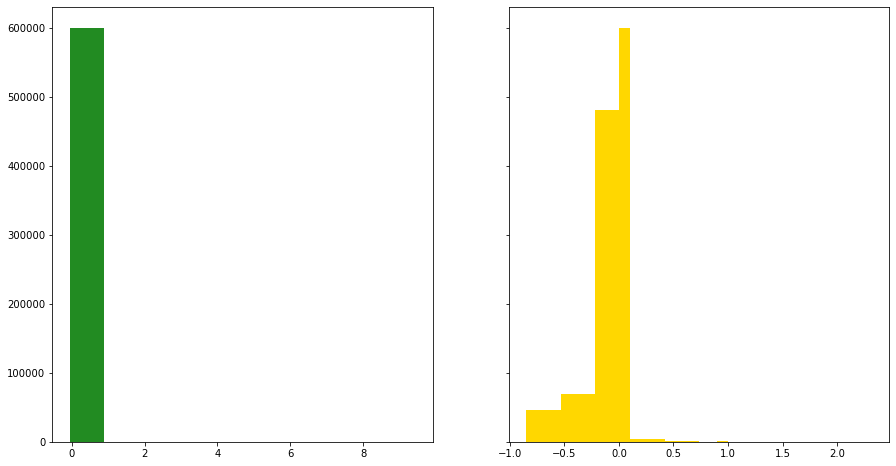

In [29]:
fig, axs = plt.subplots(1,2,figsize=(15,8), sharex=False, sharey=True)
axs = axs.ravel()
print('tau   gamma \t min fhatNEBULA \t max fhatNEBULA \t min fhatSPIRAL \t max fhatNEBULA')
for i in range(36):
    axs[0].hist(full_data['fhatNEBULA'].iloc[i], color='forestgreen')
    axs[1].hist(full_data['fhatSPIRAL'].iloc[i], color='gold')
    print('{} \t {} \t {} \t {} \t {} \t {}'.format(full_data['tau'].iloc[i][0][0],full_data['gamma'].iloc[i][0][0],min(full_data['fhatNEBULA'].iloc[i]), max(full_data['fhatNEBULA'].iloc[i]), min(full_data['fhatSPIRAL'].iloc[i]), max(full_data['fhatSPIRAL'].iloc[i])))
axs[0].set_xlabel('values')
axs[0].set_ylabel('counts')
axs[0].set_title('Distribution of values for fhatNEBULA')

axs[1].set_xlabel('values')
axs[1].set_ylabel('counts')
axs[1].set_title('Distribution of values for fhatSPIRAL')
plt.show()

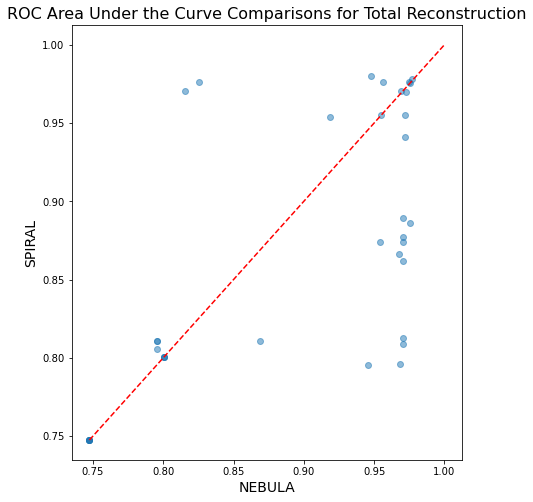

In [68]:
fig, axs = plt.subplots(figsize=(7, 8))
axs.scatter(full_data['AUC_nt'], full_data['AUC_st'], alpha=0.5)
axs.plot([min(full_data['AUC_nt']),1], [min(full_data['AUC_nt']),1], 'r--')
axs.set_xlabel('NEBULA', fontsize=14)
axs.set_ylabel('SPIRAL', fontsize=14)
axs.set_title('ROC Area Under the Curve Comparisons for Total Reconstruction', fontsize=16)
plt.show()

In [113]:
print('\t\t\t\t SPIRAL \t NEBULA')
print('Total experiments:\t\t ', len(full_data['AUC_st']),'\t\t  ', len(full_data['AUC_nt']))
print('Min ROC AUC:\t\t       ', min(full_data['AUC_st'])[0], '\t', min(full_data['AUC_nt'])[0])
print('Max ROC AUC:\t\t       ', max(full_data['AUC_st'])[0], '\t', max(full_data['AUC_nt'])[0])
print('Better performance under ROC AUC', np.sum((full_data['AUC_st'] > full_data['AUC_nt']).astype('int')),'\t\t  ', np.sum((full_data['AUC_st'] < full_data['AUC_nt']).astype('int')))

				 SPIRAL 	 NEBULA
Total experiments:		  36 		   36
Min ROC AUC:		        [0.74746117] 	 [0.74746084]
Max ROC AUC:		        [0.97988392] 	 [0.9770036]
Better performance under ROC AUC 16 		   20


In [116]:
print('\t\t\t\t SPIRAL \t NEBULA')
print('Total experiments:\t\t ', len(full_data['average_precision_St']),'\t\t  ', len(full_data['average_precision_Nt']))
print('Min AP:\t\t       ', min(full_data['average_precision_St']), '\t', min(full_data['average_precision_Nt']))
print('Max AP:\t\t       ', max(full_data['average_precision_St']), '\t', max(full_data['average_precision_Nt']))
print('Better performance Avg. Prec.', np.sum((full_data['average_precision_St'] > full_data['average_precision_Nt']).astype('int')),'\t\t  ', np.sum((full_data['average_precision_St'] < full_data['average_precision_Nt']).astype('int')))

				 SPIRAL 	 NEBULA
Total experiments:		  36 		   36
Min AP:		        0.023209868355614033 	 0.027884676104618568
Max AP:		        0.378608385999228 	 0.4014999477302984
Better performance Avg. Prec. 11 		   25


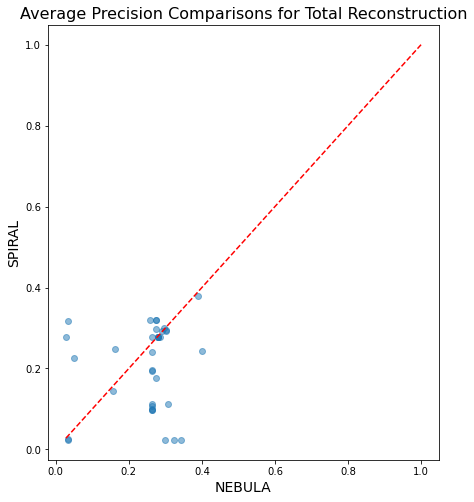

In [83]:
fig, axs = plt.subplots(figsize=(7, 8))
axs.scatter(full_data['average_precision_Nt'], full_data['average_precision_St'], alpha=0.5)
axs.plot([min(full_data['average_precision_Nt']),1], [min(full_data['average_precision_Nt']),1], 'r--')
axs.set_xlabel('NEBULA', fontsize=14)
axs.set_ylabel('SPIRAL', fontsize=14)
axs.set_title('Average Precision Comparisons for Total Reconstruction', fontsize=16)
plt.show()

# Define function to plot ROC curves

In [9]:
def compute_FPR_TPR(path, suffix = None,save=False):
    data = json.loads(open(path).read())
    fhat_SPIRAL = np.array(data['fhat_SPIRAL'])
    fhat_NEBULA = np.array(data['fhat_NEBULA'])
    f_true = np.array(data['f_true'])
    d={}
    d['fpr_SPIRAL'], d['tpr_SPIRAL'], d['thresholds_SPIRAL'] = metrics.roc_curve(f_true, fhat_SPIRAL, pos_label=1)
    d['fpr_NEBULA'], d['tpr_NEBULA'], d['thresholds_NEBULA'] = metrics.roc_curve(f_true, fhat_NEBULA, pos_label=1)
    d['roc_auc_SPIRAL'] = metrics.auc(d['fpr_SPIRAL'], d['tpr_SPIRAL'])
    d['roc_auc_NEBULA'] = metrics.auc(d['fpr_NEBULA'], d['tpr_NEBULA'])
    
    return d
def plot_ROC(params, title=None, save=False):    
    display_SPIRAL = metrics.RocCurveDisplay(fpr=params['fpr_SPIRAL'], tpr=params['tpr_SPIRAL'], roc_auc=params['roc_auc_SPIRAL'], estimator_name='SPIRAL')
    display_NEBULA = metrics.RocCurveDisplay(fpr=params['fpr_NEBULA'], tpr=params['tpr_NEBULA'], roc_auc=params['roc_auc_NEBULA'], estimator_name='NEBULA')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    if title is not None: fig.suptitle(title, fontsize=20)
    display_SPIRAL.plot(ax=ax1)
    display_NEBULA.plot(ax=ax2)
    if save: plt.savefig('%s.png'%title, format='png')
    plt.show()

# Plot results

In [10]:
os.listdir(path + 'results/100000n_50k/2Lp_4Lc')

['0.01tau_20gamma_RESULTS.mat',
 '1000tau_10gamma_RESULTS.mat',
 '10tau_200gamma_RESULTS.mat',
 '1tau_100gamma_RESULTS.mat',
 '1000tau_2gamma_RESULTS.mat',
 '1tau_200gamma_RESULTS.mat',
 '10tau_100gamma_RESULTS.mat',
 '100tau_2gamma_RESULTS.mat',
 '0.1tau_100gamma_RESULTS.mat',
 '100tau_500gamma_RESULTS.mat',
 '0.01tau_500gamma_RESULTS.mat',
 '10tau_2gamma_RESULTS.mat',
 '1000tau_100gamma_RESULTS.mat',
 '1000tau_200gamma_RESULTS.mat',
 '1tau_2gamma_RESULTS.mat',
 '0.01tau_10gamma_RESULTS.mat',
 '1000tau_20gamma_RESULTS.mat',
 '0.1tau_200gamma_RESULTS.mat',
 '10tau_500gamma_RESULTS.mat',
 '10tau_20gamma_RESULTS.mat',
 '1tau_10gamma_RESULTS.mat',
 '0.1tau_2gamma_RESULTS.mat',
 '0.1tau_20gamma_RESULTS.mat',
 '1tau_500gamma_RESULTS.mat',
 '100tau_20gamma_RESULTS.mat',
 '0.1tau_10gamma_RESULTS.mat',
 '0.01tau_200gamma_RESULTS.mat',
 '100tau_200gamma_RESULTS.mat',
 '100tau_10gamma_RESULTS.mat',
 '100tau_100gamma_RESULTS.mat',
 '0.1tau_500gamma_RESULTS.mat',
 '0.01tau_100gamma_RESULTS.mat',
 

In [7]:
d = sio.loadmat(path + 'results/100000n_50k/4Lp_2Lc/0.01tau_20gamma_RESULTS.mat')

/opt/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
d.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A', 'AT', 'AUC_nc', 'AUC_np', 'AUC_nt', 'AUC_sc', 'AUC_sp', 'AUC_st', 'A_yc', 'A_yp', 'A_zc', 'A_zp', 'B', 'N', 'T_nc', 'T_np', 'T_nt', 'T_sc', 'T_sp', 'T_st', 'X_nc', 'X_np', 'X_nt', 'X_sc', 'X_sp', 'X_st', 'Y_nc', 'Y_np', 'Y_nt', 'Y_sc', 'Y_sp', 'Y_st', 'alphaaccept', 'alphamax', 'alphamin', 'cputime_NEBULA', 'cputime_SPIRAL', 'erreps', 'f_c', 'f_h', 'f_init', 'f_n', 'f_p', 'f_p2', 'f_true', 'fhatNEBULA', 'fhatNEBULA_c', 'fhatNEBULA_h', 'fhatNEBULA_n', 'fhatNEBULA_p', 'fhatSPIRAL', 'fhatSPIRAL_c', 'fhatSPIRAL_h', 'fhatSPIRAL_n', 'fhatSPIRAL_p', 'file', 'None', 'gamma', 'gamma_vals', 'i', 'iterations_NEBULA', 'iterations_SPIRAL', 'j', 'k', 'kind', 'lambda_c', 'lambda_p', 'logepsilon', 'maxiter', 'miniter', 'mu_c', 'mu_p', 'n', 'objective_NEBULA', 'objective_SPIRAL', 'params_AUCs', 'pctNovel', 'pct_similarity', 'plot_flag', 'print', 'r', 'reconerror_NEBULA', 'reconerror_SPIRAL', 'reg_params', 'reg_params_all', 's_c', 's_obs', 's_p

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

#fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
#roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [41]:
d['fpr_SPIRAL'], d['tpr_SPIRAL'], d['thresholds_SPIRAL'] = metrics.roc_curve(d['f_true'], d['fhatSPIRAL'], pos_label=1)
d['fpr_NEBULA'], d['tpr_NEBULA'], d['thresholds_NEBULA'] = metrics.roc_curve(d['f_true'], d['fhatNEBULA'], pos_label=1)
d['roc_auc_SPIRAL'] = metrics.auc(d['fpr_SPIRAL'], d['tpr_SPIRAL'])
d['roc_auc_NEBULA'] = metrics.auc(d['fpr_NEBULA'], d['tpr_NEBULA'])

In [54]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec_st, recall_st, _ = precision_recall_curve(d['f_true'], d['fhatSPIRAL'], pos_label=1)
prec_nt, recall_nt, _ = precision_recall_curve(d['f_true'], d['fhatNEBULA'], pos_label=1)
average_precision_Nt = metrics.average_precision_score(d['f_true'], d['fhatNEBULA'])
average_precision_St = metrics.average_precision_score(d['f_true'], d['fhatSPIRAL'])

pr_curve_St = PrecisionRecallDisplay(precision=prec_st, recall=recall_st, average_precision=average_precision_St)
pr_curve_Nt = PrecisionRecallDisplay(precision=prec_nt, recall=recall_nt, average_precision=average_precision_Nt)

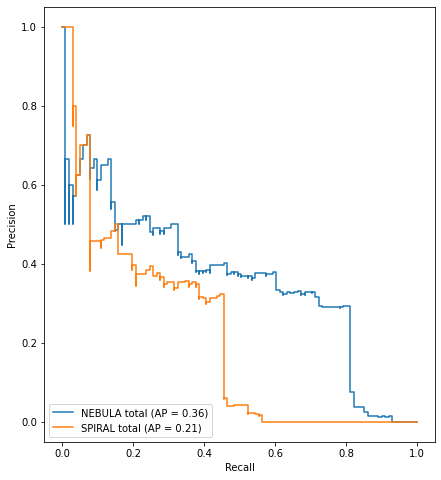

In [55]:
fig, ax = plt.subplots(figsize=(7, 8))
pr_curve_Nt.plot(ax=ax, name = 'NEBULA total')
pr_curve_St.plot(ax=ax, name='SPIRAL total')